# Simulated data

## 1: Implement subroutine generating random data

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import math

from itertools import chain

In [2]:
# Code received from Lukas
def generate_expression_data(n_analytes=100, n_samples=2, n_replicates=3, p_regulated=0.2, mean_offset=3.0, var=0.2, diff_var=2.0):
    # Here we follow a convension, The first sample is the reference i.e. have all label 1
    labels = npr.binomial(1, p_regulated, (n_analytes,n_samples-1))
    template = np.hstack((np.zeros((n_analytes,1)),labels))
    
    # We expand the template labels into several replicates
    regulated = np.repeat(template,n_replicates, axis=1)
    
    # If the reading is regulated, offset it with a random offset sampled from the normal distribution 
    offset = regulated*npr.normal(0,diff_var,(n_analytes,1))
    
    # Model a differentexpression level for the different analytes
    expr_level = np.ones((n_analytes,n_samples*n_replicates))*npr.normal(mean_offset,mean_offset,(n_analytes,1))
    
    # add noice for each measurement
    expression = npr.normal(offset+expr_level,var,(n_analytes,n_replicates*n_samples))
    expression = 2**expression
    
    analyte_names = ["a"+str(i+1) for i in range(n_analytes)]
    sample_names = ["s"+str(i+1)+'_'+str(j+1) for i in range(n_samples) for j in range(n_replicates)]
    
    # Create a dataframe for expression values
    expr_df = pd.DataFrame(expression,columns=sample_names,index=analyte_names)
    expr_df.loc["Sample",:] = [i+1 for i in range(n_samples) for j in range(n_replicates)]
    
    # Create a dataframe with answers if the reading was modeled as differential or not
    label_df = pd.DataFrame(template,columns=[i+1 for i in range(n_samples)],index=analyte_names)
                
    return expr_df,label_df

In [3]:
df = pd.read_excel("data/blood_plasma_data.xlsx", skiprows=chain(range(6),range(15,18)),parse_cols=[0]+list(range(3,318)), header=0, index_col=0)

df.head()

,_02_1,_02_2,_02_3,_02_4,_02_5,_02_6,_02_7,_03_1,_03_2,_03_3,...,_57_2,_57_3,_57_4,_57_5,_57_6,_57_7,_58_1,_58_2,_58_3,_58_4
Participant_Timepoint,,,,,,,,,,,,,,,,,,,,,
Weight,84.8,71.5,71.0,70.0,71.5,73.2,72.00,97.65,85.8,82.6,...,92.0,92.0,93.0,92.4,94.5,96.80,104.8,94.1,95.0,96.0
BMI,31.4,26.2,NaN,NaN,NaN,NaN,26.63,36.00,30.0,NaN,...,28.0,NaN,NaN,NaN,NaN,29.16,31.8,27.4,NaN,NaN
Cholesterol,5.2,4.3,NaN,NaN,NaN,NaN,4.70,4.70,3.4,NaN,...,4.0,NaN,NaN,NaN,NaN,4.30,4.0,2.8,NaN,NaN
LDL,3.2,2.6,NaN,NaN,NaN,NaN,2.90,3.00,2.0,NaN,...,2.5,NaN,NaN,NaN,NaN,2.40,2.1,1.2,NaN,NaN
HDL,1.8,1.3,NaN,NaN,NaN,NaN,1.50,1.20,0.9,NaN,...,0.9,NaN,NaN,NaN,NaN,0.90,1.5,1.3,NaN,NaN


In [4]:
target_cols = [col for col in df.columns if col[:3] in ['_1_', '_07']]
df_target = df[target_cols]
df_target.head()
sample_names = [raw.split('_')[1].strip('0') for raw in target_cols]
df_target.columns = sample_names
df_target.head(10).loc[:,'7']

,7,7,7,7,7,7,7
Participant_Timepoint,,,,,,,
Weight,97.700000,81.700000,80.500000,80.300000,80.000000,82.800000,83.000000
BMI,32.600000,27.000000,NaN,NaN,NaN,NaN,28.350000
Cholesterol,4.200000,4.200000,NaN,NaN,NaN,NaN,4.000000
LDL,2.400000,2.700000,NaN,NaN,NaN,NaN,1.900000
HDL,1.400000,1.000000,NaN,NaN,NaN,NaN,1.800000
Triglyceride,0.800000,0.900000,NaN,NaN,NaN,NaN,0.600000
HOMA-IR,4.686400,3.981778,NaN,NaN,NaN,NaN,2.846933
Leptin,26.600000,8.000000,9.240000,15.600000,14.600000,13.700000,19.000000
A0A024R6I7;A0A0G2JRN3,9.384871,9.587641,9.537764,9.472915,9.523382,9.485810,9.588928


## 3: Calculate p-values

`ttest_rel`: t-test on two related samples of scores. Participants in the two groups are related. For instance - if participants in first group are same as the one in the second group. This is also called **repeated measures design**.

`ttest_ind`: Independent. Compare groups of participants that are not related in any way. Participants in one group have no relationship to participants in second group.

In [5]:
ind_test_results = stats.ttest_ind(df_target.loc[:,'1'], df_target.loc[:,'7'], axis=1, nan_policy='propagate')
rel_test_results = stats.ttest_rel(df_target.loc[:,'1'], df_target.loc[:,'7'], axis=1, nan_policy='propagate')
ind_p_vals = [val for val in ind_test_results.pvalue if not math.isnan(val)]
rel_p_vals = [val for val in rel_test_results.pvalue if not math.isnan(val)]

print(ind_p_vals[0:10])
print(rel_p_vals[0:10])


[0.10564953063636115, 0.092181638163317953, 2.1123859738950479e-07, 0.14425823678609856, 4.1592022742555523e-08, 0.016323678234256105, 0.024121861243311546, 0.0001437072875688796, 0.10603299758776533, 0.075772181276702114]
[0.0097844920994129506, 0.0061343124332960651, 5.9901893180283276e-05, 0.23513285511642426, 5.7471600122470726e-05, 0.040514494452516689, 0.057877730230614814, 0.0024011618820409357, 0.12974808188216566, 0.021140596592115608]


/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## 4: Implement subroutine for calculating q-value

* Let p_1 <= p_2 <= p_m be ordered p-values
* For a range lambda, say lambda = 0, 0.01, 0.02.., 0.95 calculate: pi0(lambda) = # {p_j > lambda} / m(1-lambda)
* Let f be the natural cubic spline (in our case - average for high p-values)
* Set estimate of pi_0 to be: pi_0 = f(1)
* Calculate q(p(m)) = min((pi_0*m*t)/#{p_i <= t}) = pi_0 * p(m)
* For i = m - 1, m - 2, ..., 1 calculate:
* The estimated q is the ith most significant feaure is q(p(i))

In [6]:
def estimate_pis(pvals):
    
    pi_0_vals = list()
    
    for sub_thres in np.arange(0.01, 0.96, 0.01):
        sub_p = [p for p in pvals if p > sub_thres]
        sub_p_count = len(sub_p)
        m = len(pvals)
        pi_0 = sub_p_count / (m * (1-sub_thres))
        pi_0_vals.append(pi_0)
  
    return pi_0_vals

def estimate_pi_zero(pis, thres):
    
    tot = len(pis)
    start_ind = int(tot * thres)
    sub = pis[start_ind:]
    return np.mean(sub)


### Diff test

In [7]:
ind_p_vals[0:10]

[0.10564953063636115,
 0.092181638163317953,
 2.1123859738950479e-07,
 0.14425823678609856,
 4.1592022742555523e-08,
 0.016323678234256105,
 0.024121861243311546,
 0.0001437072875688796,
 0.10603299758776533,
 0.075772181276702114]

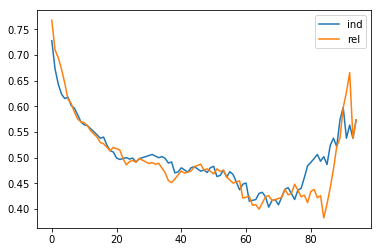

In [8]:
ind_pi_0_vals = estimate_pis(ind_p_vals)
rel_pi_0_vals = estimate_pis(rel_p_vals)
plt.plot(ind_pi_0_vals, label="ind")
plt.plot(rel_pi_0_vals, label="rel")
plt.legend()
plt.show()

#### q-value calculations

In [9]:
def estimate_q_vals(pvals):
    pi_estimates = estimate_pis(pvals)
    pi_0 = estimate_pi_zero(pi_estimates, 0.75)
    m = len(pvals)
    
    fdr_vals = list()
    for t in sorted(pvals):
        val = pi_0 * m * t / (len(fdr_vals) + 1)
        fdr_vals.append(val)

    q_vals = list()
    for sub_i in range(1, len(fdr_vals)):
        fdr_slice = fdr_vals[len(fdr_vals) - sub_i:]
        q = min(fdr_slice)
        q_vals.insert(0, q)

    print("pi_0: {}".format(pi_0))
    print("m: {}".format(len(pvals)))
    return q_vals


In [10]:
ind_q_vals = estimate_q_vals(ind_p_vals)
rel_q_vals = estimate_q_vals(rel_p_vals)


pi_0: 0.4963262324415954
m: 279
pi_0: 0.4731404942946818
m: 279


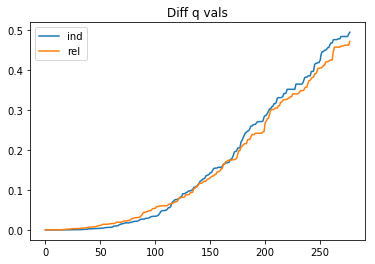

In [11]:
plt.plot(ind_q_vals, label="ind")
plt.plot(rel_q_vals, label="rel")
plt.legend()
plt.title("Diff q vals")
plt.show()

## 5: Differential expression genes, on q-threshold

In [12]:
xvals = np.arange(0, 0.5, 0.005)

In [13]:
ind_counts = list()
for thres in xvals:
    ind_count = len([q for q in ind_q_vals if q <= thres])
    ind_counts.append(ind_count)

rel_counts = list()
for thres in xvals:
    rel_count = len([q for q in rel_q_vals if q <= thres])
    rel_counts.append(rel_count)


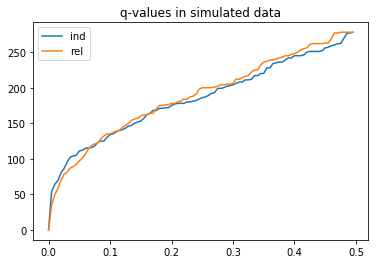

In [14]:
plt.plot(xvals, ind_counts, label="ind")
plt.plot(xvals, rel_counts, label="rel")
plt.title('q-values in simulated data')
plt.legend()
plt.show()

# 6: Differential expression results

In [15]:
print("Total values: {}".format(len(ind_q_vals)))
print("Significant independent: {}".format(len([q for q in ind_q_vals if q <= 0.01])))
print("Significant dependent: {}".format(len([q for q in rel_q_vals if q <= 0.01])))

Total values: 278
Significant independent: 64
Significant dependent: 49
